In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image dimensions
img_height, img_width = 224, 224
batch_size = 32

# Define paths
base_dir = 'C:\\Users\\haika\\AppData\\Local\\Programs\\Microsoft VS Code\\data\\split_data'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Data generators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 3649 images belonging to 10 classes.
Found 782 images belonging to 10 classes.
Found 782 images belonging to 10 classes.


In [2]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

# Load the ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Build the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



In [3]:
# Callbacks
checkpoint = ModelCheckpoint('best_resnet_model.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
tensorboard = TensorBoard(log_dir='./logs_resnet', histogram_freq=1)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[checkpoint, tensorboard]
)


Epoch 1/50
115/115 [==============================] - ETA: 0s - loss: 2.2692 - accuracy: 0.1707
Epoch 1: val_accuracy improved from -inf to 0.19949, saving model to best_resnet_model.h5
115/115 [==============================] - 29s 179ms/step - loss: 2.2692 - accuracy: 0.1707 - val_loss: 2.1473 - val_accuracy: 0.1995
Epoch 2/50
115/115 [==============================] - ETA: 0s - loss: 2.1390 - accuracy: 0.1990
Epoch 2: val_accuracy improved from 0.19949 to 0.27877, saving model to best_resnet_model.h5
115/115 [==============================] - 20s 170ms/step - loss: 2.1390 - accuracy: 0.1990 - val_loss: 2.0467 - val_accuracy: 0.2788
Epoch 3/50
115/115 [==============================] - ETA: 0s - loss: 2.0656 - accuracy: 0.2233
Epoch 3: val_accuracy did not improve from 0.27877
115/115 [==============================] - 20s 173ms/step - loss: 2.0656 - accuracy: 0.2233 - val_loss: 2.0382 - val_accuracy: 0.2711
Epoch 4/50
115/115 [==============================] - ETA: 0s - loss: 2.0589

25/25 [==============================] - 3s 83ms/step
Accuracy: 0.43478260869565216
mAP: 0.4600513405104607


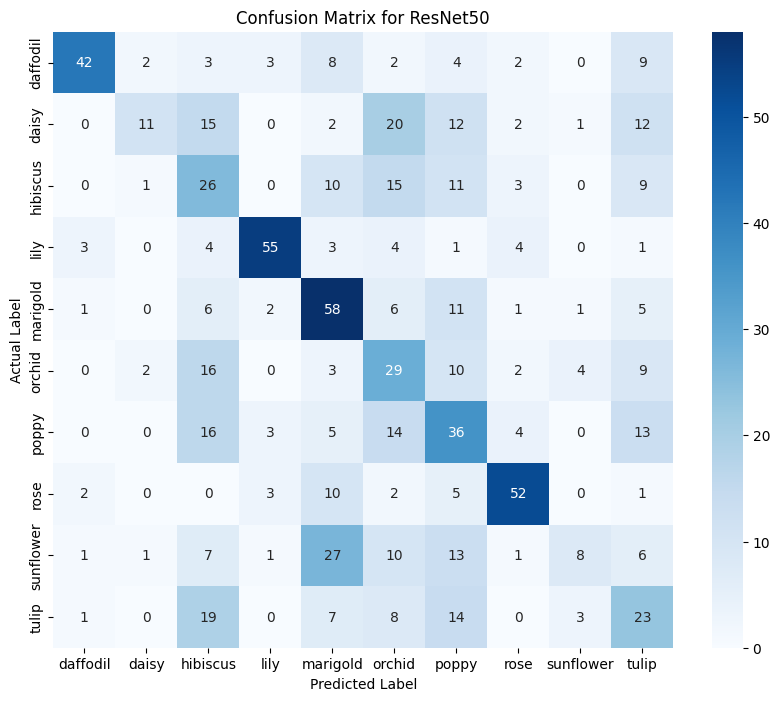

Classification Report for ResNet50
              precision    recall  f1-score   support

    daffodil       0.84      0.56      0.67        75
       daisy       0.65      0.15      0.24        75
    hibiscus       0.23      0.35      0.28        75
        lily       0.82      0.73      0.77        75
    marigold       0.44      0.64      0.52        91
      orchid       0.26      0.39      0.31        75
       poppy       0.31      0.40      0.35        91
        rose       0.73      0.69      0.71        75
   sunflower       0.47      0.11      0.17        75
       tulip       0.26      0.31      0.28        75

    accuracy                           0.43       782
   macro avg       0.50      0.43      0.43       782
weighted avg       0.50      0.43      0.43       782



In [4]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, average_precision_score
import matplotlib.pyplot as plt

# Load the best model
model = tf.keras.models.load_model('best_resnet_model.h5')

# Predict using the loaded model
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_pred_labels = np.argmax(y_pred, axis=1)

# Accuracy and mAP calculation
accuracy = accuracy_score(y_true, y_pred_labels)
mean_ap = average_precision_score(tf.keras.utils.to_categorical(y_true), y_pred)

print(f"Accuracy: {accuracy}")
print(f"mAP: {mean_ap}")

# Confusion matrix
conf_mat = confusion_matrix(y_true, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix for ResNet50')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Print the classification report
print('Classification Report for ResNet50')
print(classification_report(y_true, y_pred_labels, target_names=test_generator.class_indices.keys()))


Found 3649 images belonging to 10 classes.
Found 782 images belonging to 10 classes.
Found 782 images belonging to 10 classes.
Epoch 1/100
115/115 [==============================] - ETA: 0s - loss: 2.2930 - accuracy: 0.1705
Epoch 1: val_accuracy improved from -inf to 0.16113, saving model to best_resnet50_model.h5
115/115 [==============================] - 23s 173ms/step - loss: 2.2930 - accuracy: 0.1705 - val_loss: 2.1799 - val_accuracy: 0.1611
Epoch 2/100
115/115 [==============================] - ETA: 0s - loss: 2.1438 - accuracy: 0.2001
Epoch 2: val_accuracy improved from 0.16113 to 0.20972, saving model to best_resnet50_model.h5
115/115 [==============================] - 19s 163ms/step - loss: 2.1438 - accuracy: 0.2001 - val_loss: 2.0872 - val_accuracy: 0.2097
Epoch 3/100
115/115 [==============================] - ETA: 0s - loss: 2.0837 - accuracy: 0.2277
Epoch 3: val_accuracy improved from 0.20972 to 0.28005, saving model to best_resnet50_model.h5
115/115 [=======================

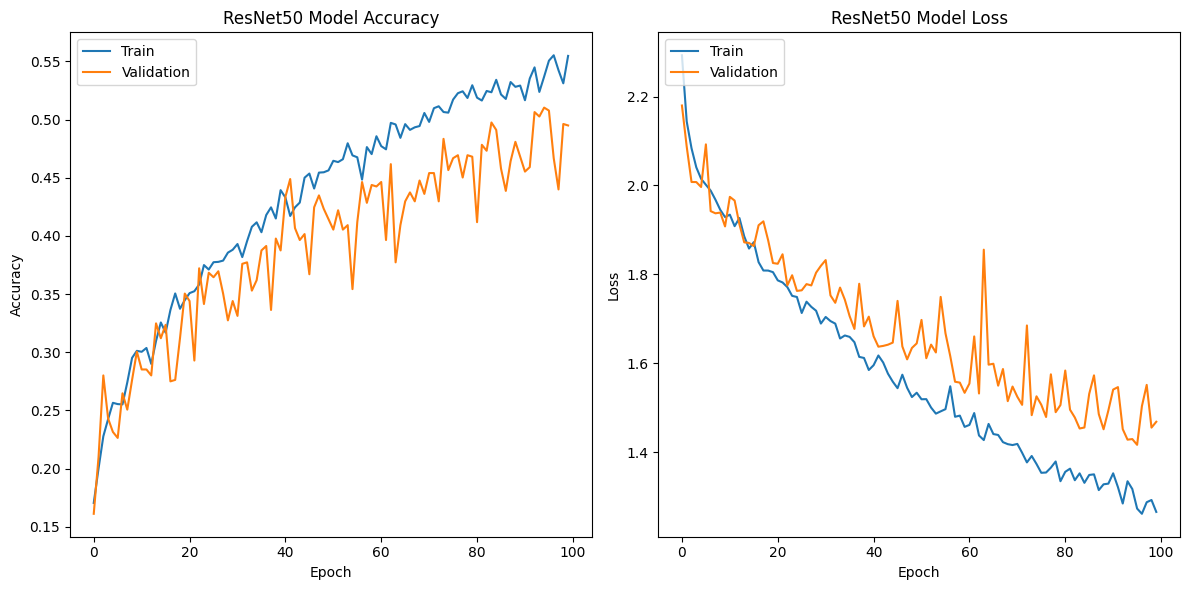

25/25 [==============================] - 3s 106ms/step
Accuracy: 0.4948849104859335
mAP: 0.5375714741775619


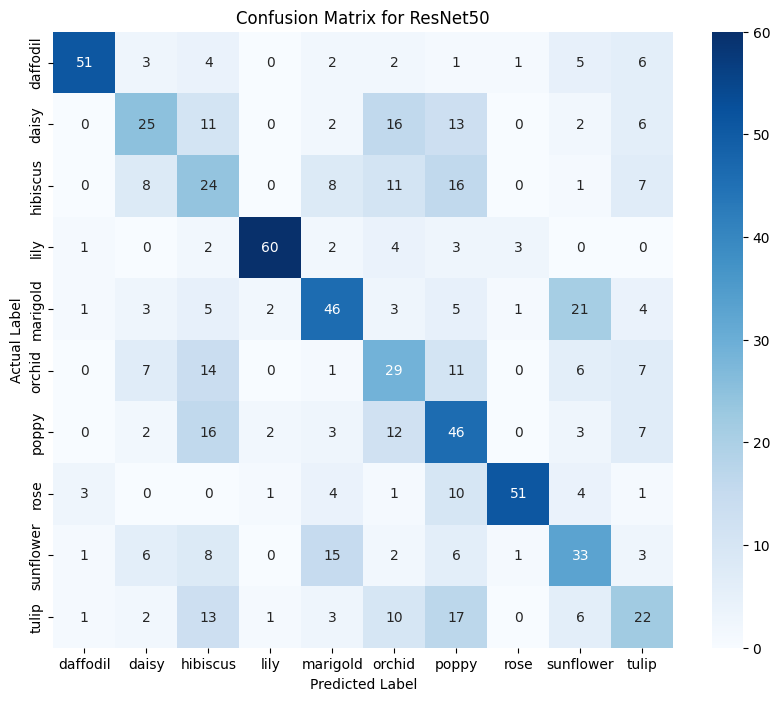

Classification Report for ResNet50
              precision    recall  f1-score   support

    daffodil       0.88      0.68      0.77        75
       daisy       0.45      0.33      0.38        75
    hibiscus       0.25      0.32      0.28        75
        lily       0.91      0.80      0.85        75
    marigold       0.53      0.51      0.52        91
      orchid       0.32      0.39      0.35        75
       poppy       0.36      0.51      0.42        91
        rose       0.89      0.68      0.77        75
   sunflower       0.41      0.44      0.42        75
       tulip       0.35      0.29      0.32        75

    accuracy                           0.49       782
   macro avg       0.54      0.49      0.51       782
weighted avg       0.53      0.49      0.51       782



In [5]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, average_precision_score
import matplotlib.pyplot as plt

# Define image dimensions
img_height, img_width = 224, 224
batch_size = 32

# Define paths
base_dir = 'C:\\Users\\haika\\AppData\\Local\\Programs\\Microsoft VS Code\\data\\split_data'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Data generators without additional preprocessing
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Load the ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Build the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('best_resnet50_model.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
tensorboard = TensorBoard(log_dir='./logs_resnet50', histogram_freq=1)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=100,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[checkpoint, tensorboard]
)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('ResNet50 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('ResNet50 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# Load the best model
model = tf.keras.models.load_model('best_resnet50_model.h5')

# Predict using the loaded model
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_pred_labels = np.argmax(y_pred, axis=1)

# Accuracy and mAP calculation
accuracy = accuracy_score(y_true, y_pred_labels)
mean_ap = average_precision_score(tf.keras.utils.to_categorical(y_true), y_pred)

print(f"Accuracy: {accuracy}")
print(f"mAP: {mean_ap}")

# Confusion matrix
conf_mat = confusion_matrix(y_true, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix for ResNet50')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Print the classification report
print('Classification Report for ResNet50')
print(classification_report(y_true, y_pred_labels, target_names=test_generator.class_indices.keys()))


Found 3649 images belonging to 10 classes.
Found 782 images belonging to 10 classes.
Found 782 images belonging to 10 classes.
Epoch 1/20
115/115 [==============================] - ETA: 0s - loss: 1.7355 - accuracy: 0.4889
Epoch 1: val_accuracy improved from -inf to 0.70844, saving model to best_resnet50_model.h5
115/115 [==============================] - 37s 296ms/step - loss: 1.7355 - accuracy: 0.4889 - val_loss: 0.8638 - val_accuracy: 0.7084
Epoch 2/20
115/115 [==============================] - ETA: 0s - loss: 1.0105 - accuracy: 0.6574
Epoch 2: val_accuracy improved from 0.70844 to 0.73146, saving model to best_resnet50_model.h5
115/115 [==============================] - 33s 283ms/step - loss: 1.0105 - accuracy: 0.6574 - val_loss: 0.7915 - val_accuracy: 0.7315
Epoch 3/20
115/115 [==============================] - ETA: 0s - loss: 0.9050 - accuracy: 0.6964
Epoch 3: val_accuracy improved from 0.73146 to 0.77749, saving model to best_resnet50_model.h5
115/115 [==========================

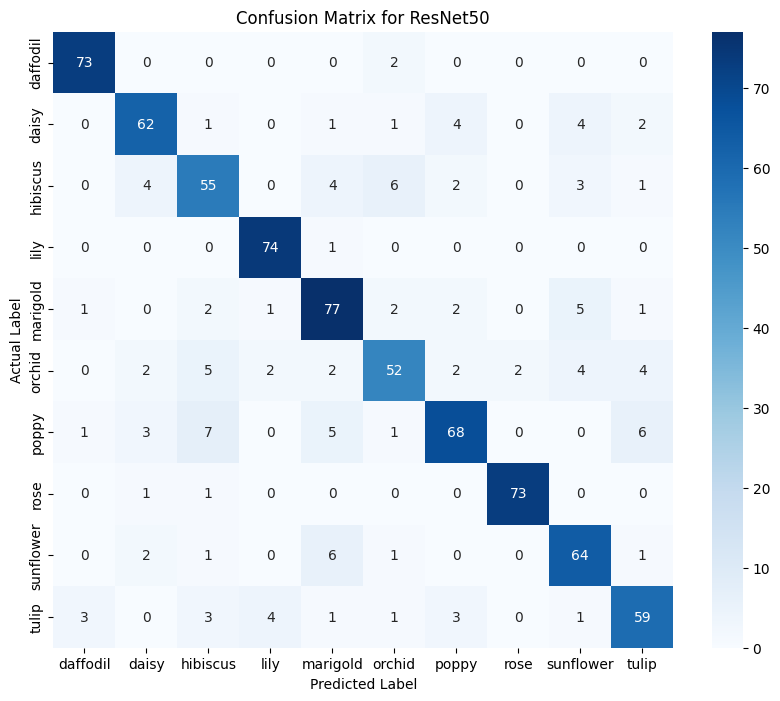

Classification Report for ResNet50
              precision    recall  f1-score   support

    daffodil       0.94      0.97      0.95        75
       daisy       0.84      0.83      0.83        75
    hibiscus       0.73      0.73      0.73        75
        lily       0.91      0.99      0.95        75
    marigold       0.79      0.85      0.82        91
      orchid       0.79      0.69      0.74        75
       poppy       0.84      0.75      0.79        91
        rose       0.97      0.97      0.97        75
   sunflower       0.79      0.85      0.82        75
       tulip       0.80      0.79      0.79        75

    accuracy                           0.84       782
   macro avg       0.84      0.84      0.84       782
weighted avg       0.84      0.84      0.84       782



In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, average_precision_score
import matplotlib.pyplot as plt
import time

# Define image dimensions
img_height, img_width = 224, 224
batch_size = 32

# Define paths
base_dir = 'C:\\Users\\haika\\AppData\\Local\\Programs\\Microsoft VS Code\\data\\split_data'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Data generators with augmentation
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Load the ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Add dropout for regularization
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Build the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('best_resnet50_model.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
tensorboard = TensorBoard(log_dir='./logs_resnet50', histogram_freq=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Train the model
start_time = time.time()
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=20,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[checkpoint, tensorboard, early_stopping]
)
training_time = time.time() - start_time

# Load the best model
model = tf.keras.models.load_model('best_resnet50_model.h5')

# Predict using the loaded model
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_pred_labels = np.argmax(y_pred, axis=1)

# Accuracy and mAP calculation
accuracy = accuracy_score(y_true, y_pred_labels)
mean_ap = average_precision_score(tf.keras.utils.to_categorical(y_true), y_pred)

print(f"Accuracy: {accuracy}")
print(f"mAP: {mean_ap}")
print(f"Training Time: {training_time} seconds")

# Confusion matrix
conf_mat = confusion_matrix(y_true, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix for ResNet50')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Print the classification report
print('Classification Report for ResNet50')
print(classification_report(y_true, y_pred_labels, target_names=test_generator.class_indices.keys()))


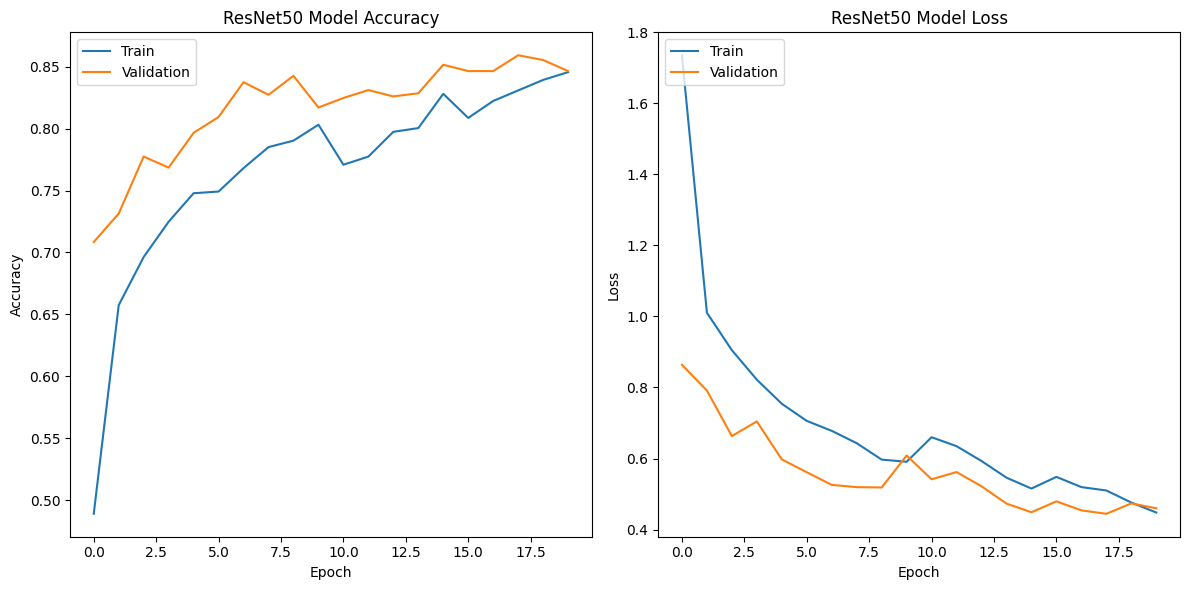

25/25 [==============================] - 3s 91ms/step
Accuracy: 0.840153452685422
mAP: 0.923998309502825


In [3]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('ResNet50 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('ResNet50 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# Load the best model
model = tf.keras.models.load_model('best_resnet50_model.h5')

# Predict using the loaded model
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_pred_labels = np.argmax(y_pred, axis=1)

# Accuracy and mAP calculation
accuracy = accuracy_score(y_true, y_pred_labels)
mean_ap = average_precision_score(tf.keras.utils.to_categorical(y_true), y_pred)

print(f"Accuracy: {accuracy}")
print(f"mAP: {mean_ap}")

Found 3649 images belonging to 10 classes.
Found 782 images belonging to 10 classes.
Found 782 images belonging to 10 classes.
Epoch 1/50
115/115 [==============================] - ETA: 0s - loss: 1.6873 - accuracy: 0.4941
Epoch 1: val_accuracy improved from -inf to 0.65473, saving model to best_resnet50_model.h5
115/115 [==============================] - 36s 295ms/step - loss: 1.6873 - accuracy: 0.4941 - val_loss: 1.0220 - val_accuracy: 0.6547
Epoch 2/50
115/115 [==============================] - ETA: 0s - loss: 1.0779 - accuracy: 0.6391
Epoch 2: val_accuracy improved from 0.65473 to 0.75448, saving model to best_resnet50_model.h5
115/115 [==============================] - 35s 298ms/step - loss: 1.0779 - accuracy: 0.6391 - val_loss: 0.7295 - val_accuracy: 0.7545
Epoch 3/50
115/115 [==============================] - ETA: 0s - loss: 0.9240 - accuracy: 0.6901
Epoch 3: val_accuracy did not improve from 0.75448
115/115 [==============================] - 35s 301ms/step - loss: 0.9240 - accu

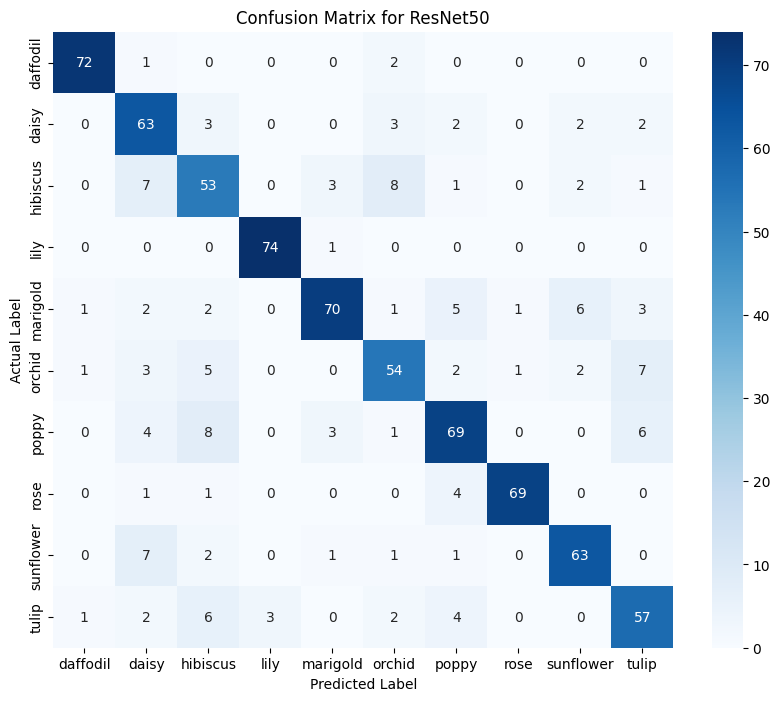

Classification Report for ResNet50
              precision    recall  f1-score   support

    daffodil       0.96      0.96      0.96        75
       daisy       0.70      0.84      0.76        75
    hibiscus       0.66      0.71      0.68        75
        lily       0.96      0.99      0.97        75
    marigold       0.90      0.77      0.83        91
      orchid       0.75      0.72      0.73        75
       poppy       0.78      0.76      0.77        91
        rose       0.97      0.92      0.95        75
   sunflower       0.84      0.84      0.84        75
       tulip       0.75      0.76      0.75        75

    accuracy                           0.82       782
   macro avg       0.83      0.83      0.83       782
weighted avg       0.83      0.82      0.82       782



In [4]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, average_precision_score
import matplotlib.pyplot as plt
import time

# Define image dimensions
img_height, img_width = 224, 224
batch_size = 32

# Define paths
base_dir = 'C:\\Users\\haika\\AppData\\Local\\Programs\\Microsoft VS Code\\data\\split_data'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Data generators with augmentation
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Load the ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Add dropout for regularization
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Build the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('best_resnet50_model.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
tensorboard = TensorBoard(log_dir='./logs_resnet50', histogram_freq=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Train the model
start_time = time.time()
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[checkpoint, tensorboard, early_stopping]
)
training_time = time.time() - start_time


# Load the best model
model = tf.keras.models.load_model('best_resnet50_model.h5')

# Predict using the loaded model
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_pred_labels = np.argmax(y_pred, axis=1)

# Accuracy and mAP calculation
accuracy = accuracy_score(y_true, y_pred_labels)
mean_ap = average_precision_score(tf.keras.utils.to_categorical(y_true), y_pred)

print(f"Accuracy: {accuracy}")
print(f"mAP: {mean_ap}")
print(f"Training Time: {training_time} seconds")

# Confusion matrix
conf_mat = confusion_matrix(y_true, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix for ResNet50')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Print the classification report
print('Classification Report for ResNet50')
print(classification_report(y_true, y_pred_labels, target_names=test_generator.class_indices.keys()))


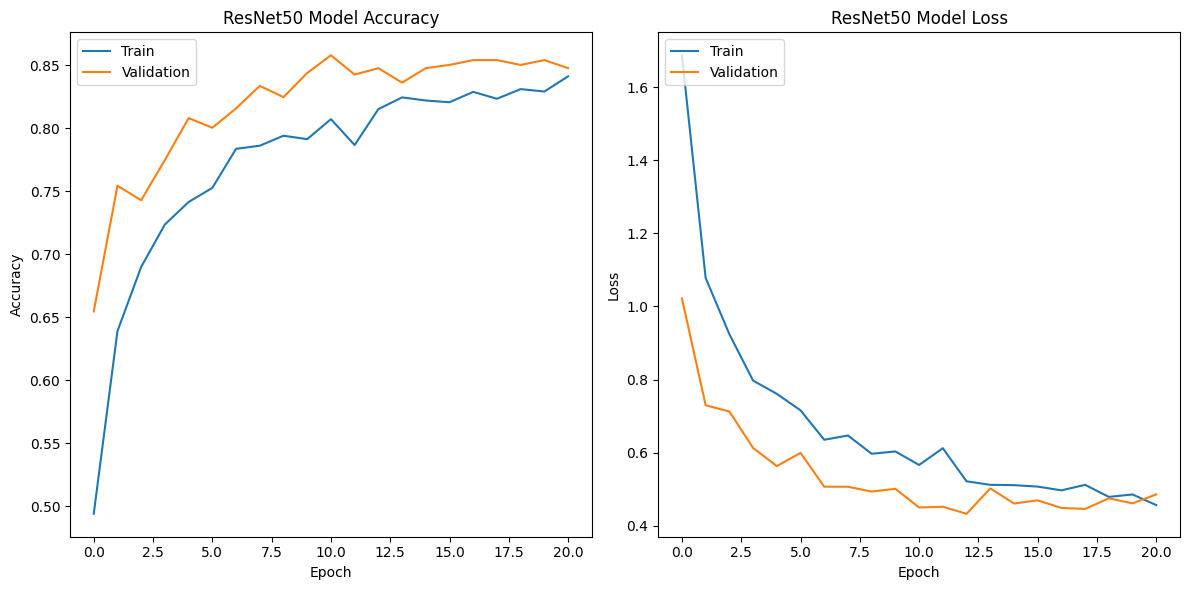

25/25 [==============================] - 3s 83ms/step
Accuracy: 0.8235294117647058
mAP: 0.9156397145264281


In [5]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('ResNet50 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('ResNet50 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# Load the best model
model = tf.keras.models.load_model('best_resnet50_model.h5')

# Predict using the loaded model
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_pred_labels = np.argmax(y_pred, axis=1)

# Accuracy and mAP calculation
accuracy = accuracy_score(y_true, y_pred_labels)
mean_ap = average_precision_score(tf.keras.utils.to_categorical(y_true), y_pred)

print(f"Accuracy: {accuracy}")
print(f"mAP: {mean_ap}")